## Necessary Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

C:\Users\Hamed Khashehchi\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hamed Khashehchi\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hamed Khashehchi\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hamed Khas

In [2]:
num_factors = 32
training_coef = 1e-7

In [3]:
tf.__version__

'1.9.0'

## Reading all data from hard

In [4]:
path = os.path.join(os.path.abspath(''), "MovieLens/ml-25m")
movies = pd.read_csv(os.path.join(path, 'movies.csv'))
rating=pd.read_csv(os.path.join(path, "ratings.csv"))
link=pd.read_csv(os.path.join(path, "links.csv"))
g_score=pd.read_csv(os.path.join(path, "genome-scores.csv"))
g_tag=pd.read_csv(os.path.join(path, "genome-tags.csv"))
tag=pd.read_csv(os.path.join(path, "tags.csv"))

## Showing some data for understanding

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
tag.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [7]:
g_tag.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [9]:
user = rating.userId.values.astype('int32').reshape(-1, 1)
user

array([[     1],
       [     1],
       [     1],
       ...,
       [162541],
       [162541],
       [162541]])

In [10]:
item = rating.movieId.values.astype('int32').reshape(-1, 1)
item

array([[  296],
       [  306],
       [  307],
       ...,
       [56176],
       [58559],
       [63876]])

In [11]:
rate = rating.rating.values.astype('int32').reshape(-1, 1)
rate

array([[5],
       [3],
       [5],
       ...,
       [2],
       [4],
       [5]])

In [12]:
num_items = np.unique(item).shape[0]
num_items

59047

In [13]:
num_users = np.unique(user).shape[0]
num_users

162541

In [14]:
num_items = item.max() + 1
num_items

209172

In [15]:
rating_num = rate.shape[0]
rating_num

25000095

In [16]:
index = np.arange(rating_num)
np.random.shuffle(index)
split_range = rating_num//16

In [17]:
val_user = user[index[:split_range]]
val_item = item[index[:split_range]]
val_rate = rate[index[:split_range]]

In [18]:
train_user = user[index[split_range:]]
train_item = item[index[split_range:]]
train_rate = rate[index[split_range:]]

In [19]:
def prepare_batches(seq, step):
    n = len(seq)
    res = []
    for i in range(0, n, step):
        res.append(seq[i:i+step])
    return res

In [20]:
def embed(inputs, size, dim, name=None):
    std = np.sqrt(2 / dim)
    emb = tf.Variable(tf.random_uniform([size, dim], -std, std), name=name)
    lookup = tf.nn.embedding_lookup(emb, inputs)
    return lookup


graph = tf.Graph()
graph.seed = 1

with graph.as_default():
    place_user = tf.placeholder(tf.int32, shape=(None, 1))
    place_item = tf.placeholder(tf.int32, shape=(None, 1))
    place_y = tf.placeholder(tf.float32, shape=(None, 1))
    
    user_factors = embed(place_user, num_users, num_factors, "user_factors")
    user_bias = embed(place_user, num_users, 1, "user_bias")
    user_bias = tf.reshape(user_bias, [-1, 1])
    
    item_factors = embed(place_item, num_items, num_factors, "item_factors")
    item_bias = embed(place_item, num_items, 1, "item_bias")
    item_bias = tf.reshape(item_bias, [-1, 1])

    global_bias = tf.Variable(0.0, name='global_bias')

    pred = tf.reduce_sum(tf.multiply(user_factors, item_factors), axis=2)
    pred = global_bias + user_bias + item_bias + pred

    reg = training_coef * tf.reduce_sum(tf.multiply(user_factors, user_factors)) + training_coef * tf.reduce_sum(tf.multiply(item_factors, item_factors))
    loss = tf.losses.mean_squared_error(place_y, pred)
    loss_total = loss + reg

    opt = tf.train.AdamOptimizer(learning_rate=0.01)
    step = opt.minimize(loss_total)


    init = tf.global_variables_initializer()


session = tf.Session(config=None, graph=graph)
session.run(init)

In [21]:
val_losses = []
epochs = 10
for i in range(epochs):
    train_index = np.arange(train_rate.shape[0])
    np.random.shuffle(train_index)
    batches = prepare_batches(train_index, 100000)

    for idx in batches:
        feed_dict = {
            place_user: train_user[idx],
            place_item: train_item[idx],
            place_y: train_rate[idx],
        }
        session.run(step, feed_dict)
    
    feed_dict = {
        place_user: val_user,
        place_item: val_item,
        place_y: val_rate,
    }
    l = session.run(loss, feed_dict)
    val_losses.append(l)
    print('epoch %02d, mse: %0.3f' % (i, l))

epoch 00, mse: 0.841
epoch 01, mse: 0.747
epoch 02, mse: 0.712
epoch 03, mse: 0.698
epoch 04, mse: 0.693
epoch 05, mse: 0.691
epoch 06, mse: 0.691
epoch 07, mse: 0.693
epoch 08, mse: 0.694
epoch 09, mse: 0.695


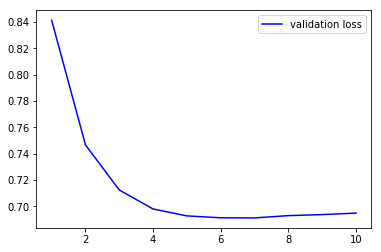

In [22]:
plt.plot(np.arange(1, epochs+1), val_losses, color='blue', label='validation loss')
plt.legend()
plt.show()